In [1]:
import scipy
import numpy as np
import neurodsp
import glob
import matplotlib.pyplot as plt

Meeting notes

(file_7_timebegin - file_6_timebegin)/60

get file recording gap in minute 


# General Pipeline Guidelines
- Analysis: https://neurodsp-tools.github.io/neurodsp/
- Compute PSD https://neurodsp-tools.github.io/neurodsp/auto_tutorials/spectral/plot_SpectralPower.html#sphx-glr-auto-tutorials-spectral-plot-spectralpower-py
- time-frequency spectrograms: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html#sphx-glr-auto-tutorials-timefreq-plot-morletwavelet-py
- Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise

Notes and to-do:
- Add data summary table: file duration, file recording gap (time_begine - time_end), sampling rate
- check stream data ID formate (possible timestamp?
- run all analysis on the CLFP_RAW data (no filtering from the machine)
- clip a 30-sec baseline LFP for FOOOF analysis (clean data input)
- 814 data_7 may be the post-operation recording 
- Finalize a pipleline that will identify the correct session file for pre vs post op besides visual examination
- double check if FOOOF is taking log or no-log power spectrum


# Data Loading

In [2]:
# Loading data from data folder
local_directory = '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926'
mat_files = glob.glob(f'{local_directory}/*.mat')
mat_files

['/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0001.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0002.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0003.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0004.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0005.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0006.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0007.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0008.mat']

In [6]:
# Data concatenation (may or may not needed)
CLFP_all = np.array([])
rec_time = np.array([])

for m in mat_files:
    file = scipy.io.loadmat(m)
    CLFP_01 = file['CLFP_01'].flatten()
    CLFP_all = np.concatenate([CLFP_all, CLFP_01], axis=None)
    CLFP_hz = file['CLFP_01_KHz'].flatten()*1000

    # print(CLFP_01.shape)
    #save file recording duration
    rec = CLFP_01.shape[0]/(60*CLFP_hz)
    rec_time = np.concatenate([rec_time, rec], axis=None)

print("recording duration for each file in second \n", rec_time)

recording duration for each file in second 
 [0.02432727 0.71312727 8.69670303 5.39709091 0.1985697  0.54864242
 4.74476364 9.54635152]


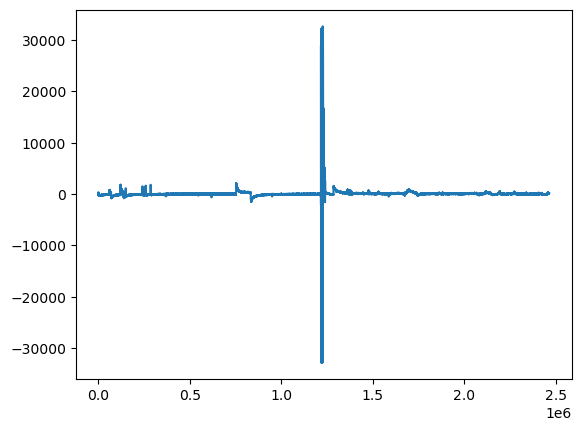

In [7]:
# All data quick visualization
CLFP_all
plt.plot(CLFP_all)

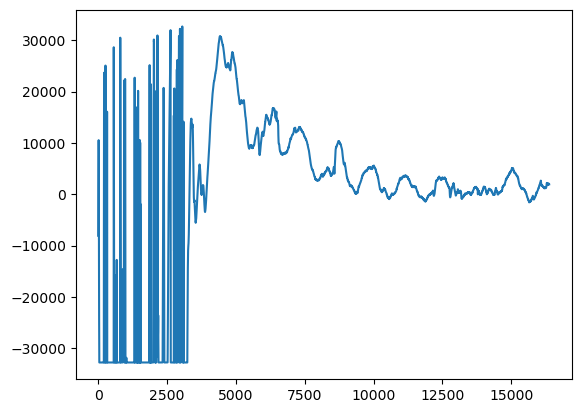

In [9]:
# single data file examination
mat_file = scipy.io.loadmat(mat_files[4])
CLFP_01 = mat_file['CLFP_01']
plt.plot(CLFP_01[0,:])

# Power spectral
This code block generate power spectral for each individual recording session for quick visualization of the session quality.


NOTES:
- There seems to be a harware filter at 60 hz, no peak signal at 60 hz from the power spectral graph.
- Need to ask all the hardware filter that has been applied to the raw data. 

In [10]:
# Import spectral power functions
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

In [13]:
#plot for each file 
freq_list = []
psd_list = []

for m in mat_files:
    file = scipy.io.loadmat(m)
    CLFP_01 = file['CLFP_01'].flatten()
    CLFP_hz = file['CLFP_01_KHz'].flatten()*1000
    freq_mean, psd_mean = compute_spectrum(CLFP_01, CLFP_hz, method='welch', avg_type='mean', nperseg=CLFP_hz*2)

    #subset the frequence range below 120 hz
    new_freq = freq_mean[freq_mean<120]
    new_psd = psd_mean[freq_mean<120]
    freq_list.append(new_freq)
    psd_list.append(new_psd)


c:\Users\fuq01\Anaconda3\envs\LFPAnalysis\Lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 2750 is greater than input length  = 2007, using nperseg = 2007
  warnings.warn('nperseg = {0:d} is greater than input length '


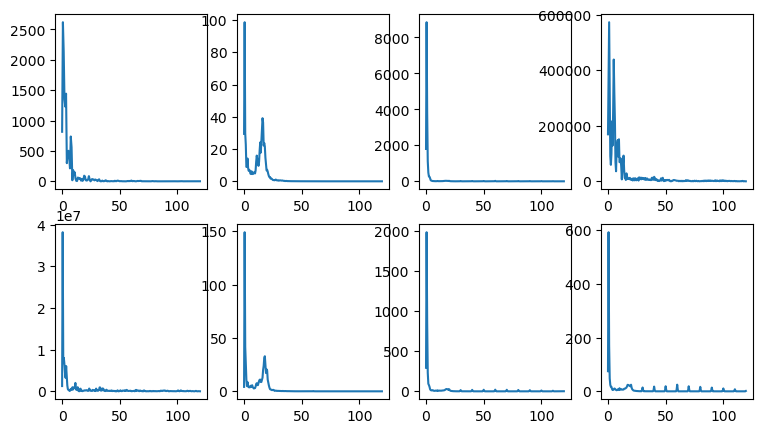

In [14]:
f, ax = plt.subplots(2,4, figsize=(9,5))

ax[0,0].plot(freq_list[0], psd_list[0])
ax[0,1].plot(freq_list[1], psd_list[1])
ax[0,2].plot(freq_list[2], psd_list[2])
ax[0,3].plot(freq_list[3], psd_list[3])

ax[1,0].plot(freq_list[4], psd_list[4])
ax[1,1].plot(freq_list[5], psd_list[5])
ax[1,2].plot(freq_list[6], psd_list[6])
ax[1,3].plot(freq_list[7], psd_list[7])

 [0.02432727 0.71312727 8.69670303 5.39709091 0.1985697  0.54864242
 4.74476364 9.54635152]

# Pre-processing IIR filtering

Note:
- bandstop, exclusion.
- bandpass, inclusion. 

In [18]:
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
from neurodsp.filt import filter_signal

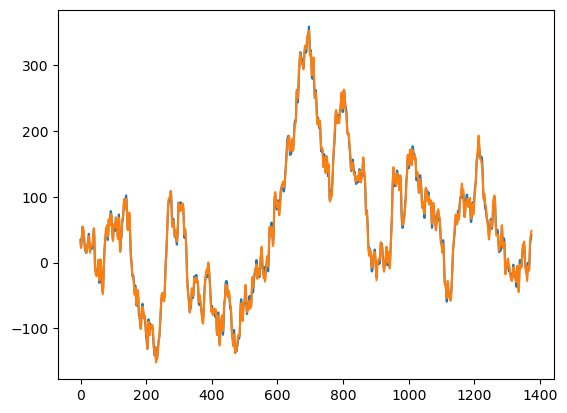

In [19]:
#filtering test
f_range = (58, 62)
sig_filt = filter_signal(CLFP_all, CLFP_hz, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
plt.plot(sig_filt[0:1375]) #filtered
plt.plot(CLFP_all[0:1375]) #raw

In [ ]:
# # tutorial testing

# from neurodsp.filt.iir import design_iir_filter, apply_iir_filter
# from neurodsp.filt.utils import compute_frequency_response, compute_transition_band
# Import plotting functions
# from neurodsp.plts import plot_frequency_response, plot_time_series

# n_seconds = 1
# fs = 1000

# # Define filter settings
# pass_type = 'bandstop'
# f_range = (58, 62) #freq range to filter out
# butterworth_order = 12

# # Design the filter, getting the second-order series (sos) values for the filter
# sos = design_iir_filter(fs, pass_type, f_range, butterworth_order)

# # Compute the frequency response for the IIR filter
# f_db, db = compute_frequency_response(sos, None, fs)

# # Plot the frequency response
# plot_frequency_response(f_db, db)

In [ ]:
# note for visualization 
# ax.set_xticklabels(np.round(new_freqs[np.linspace(0, len(new_freqs)-1, 6).astype(int)]))
# np.round(freq_mean[np.linspace(0, len(freq_mean)-1, 6).astype(int)])

# FOOOF  
- https://fooof-tools.github.io/fooof/
- https://github.com/valentinealissa/FOOOFy 

In [20]:
# Import the FOOOF object
from fooof import FOOOF


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 32 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

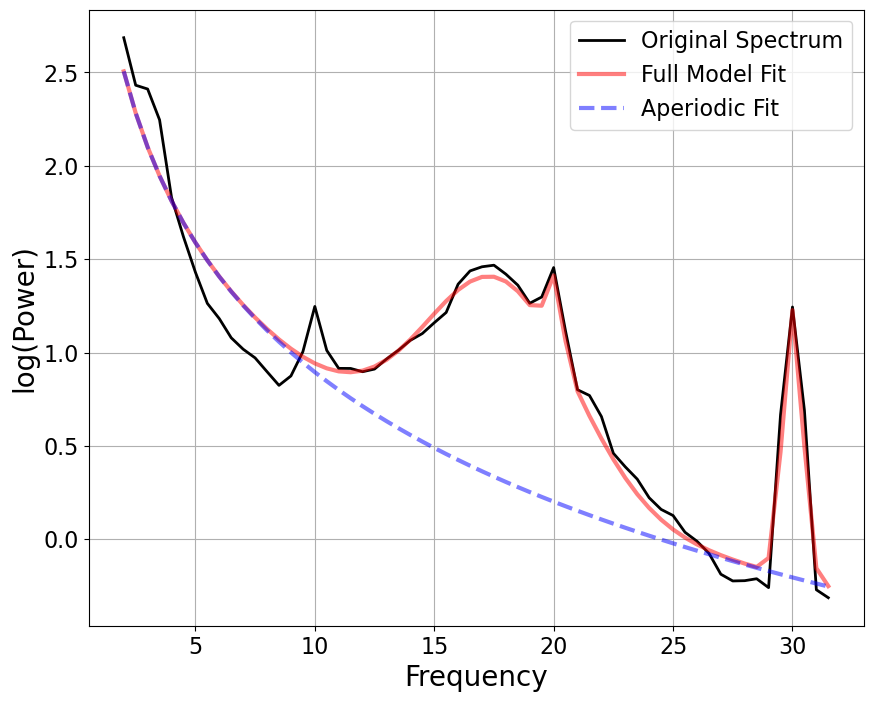

In [25]:
# Recording sessino 3: putative pre-op

# Initialize FOOOF object
fm = FOOOF()

# Define frequency range across which to model the spectrum
freq_range = [2, 32]

# Model the power spectrum with FOOOF, and print out a report
fm.report(freq_list[2], psd_list[2], freq_range)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 32 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

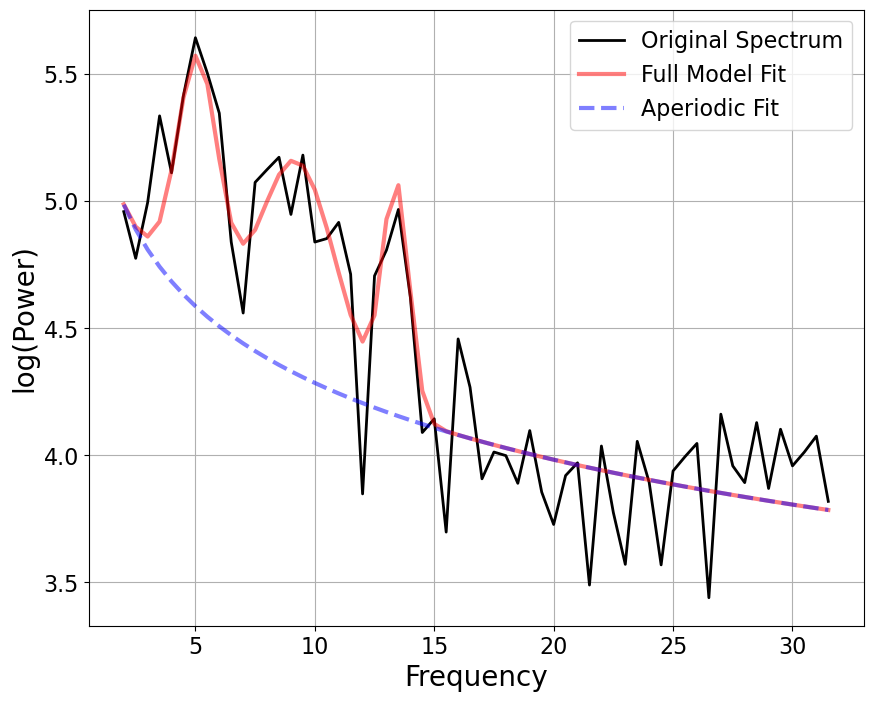

In [26]:
# Recording sessino 4: putative post-op

# nitialize FOOOF object
fm = FOOOF()
# Define frequency range across which to model the spectrum
freq_range = [2, 32] #beta edge

# Model the power spectrum with FOOOF, and print out a report
fm.report(freq_list[3], psd_list[3], freq_range)